# Popularity-Based Method

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [221]:
ratings = pd.read_csv("./Data/ratings.csv")
movies = pd.read_csv("./Data/movies_v2.csv")
movies = movies.set_index('movieId')

## Overall Popularity

How to measure? Number of users that have seen it + average rating

In [222]:
ratings.movieId.nunique()

9724

In [223]:
pop_data = ratings.groupby('movieId').rating.agg(['mean', 'size', 'sum'])

<AxesSubplot:>

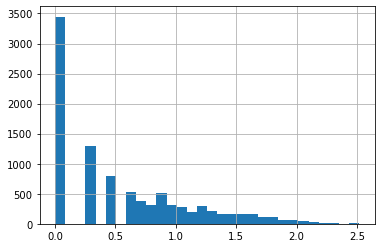

In [224]:
pop_data.sort_values('size')['size'].apply(np.log10).hist(bins=30)

A lot of movies have only been watched once (close to one third). Therefore, consider recommending based on the sum of the ratings, as it considers quality and quantity of people that watched it.

In [225]:
top_n_sum = pop_data.sort_values('sum', ascending=False).index[:10]
movies.loc[top_n_sum].title

movieId
318              Shawshank Redemption, The
356                           Forrest Gump
296                           Pulp Fiction
2571                           Matrix, The
593              Silence of the Lambs, The
260     Star Wars: Episode IV - A New Hope
110                             Braveheart
2959                            Fight Club
527                       Schindler's List
480                          Jurassic Park
Name: title, dtype: object

Encapsulating process in a function: 

In [226]:
def popularity(n, ratings, movies):
    pop_data = ratings.groupby('movieId').rating.agg(['sum', 'mean'])
    top_n_movies = pop_data['sum'].nlargest(n).index
    
    result = movies.loc[top_n_movies].merge(pop_data, on='movieId', how='inner')[['title', 'mean']]
    result['mean'] = round(result['mean'], 2)
    result.columns = ['Title', 'Average Rating']
    result
    return result.reset_index(drop=True)

In [227]:
popularity(10, ratings, movies)

,Title,Average Rating
0,"Shawshank Redemption, The",4.43
1,Forrest Gump,4.16
2,Pulp Fiction,4.20
3,"Matrix, The",4.19
4,"Silence of the Lambs, The",4.16
5,Star Wars: Episode IV - A New Hope,4.23
6,Braveheart,4.03
7,Fight Club,4.27
8,Schindler's List,4.22
9,Jurassic Park,3.75


## Popularity by Dates

Consider dates to allow new movies to be recommended as well: 

In [228]:
ratings['time'] = ratings.timestamp.apply(lambda x: datetime.fromtimestamp(x).strftime("%d-%m-%Y %I:%M:%S"))
ratings['time'] = pd.to_datetime(ratings.time, format = "%d-%m-%Y %I:%M:%S")
ratings = ratings.drop('timestamp', axis=1)

Create function to filter data by selected period: 

In [188]:
def filter_time(ratings, by='all_time', num=1):
    today = ratings.time.max()
    if by == 'day': filter_date = today - pd.DateOffset(days=num)
    elif by == 'month': filter_date = today - pd.DateOffset(months=num)
    elif by == 'year': filter_date = today - pd.DateOffset(years=num)
    else: filter_date = ratings.time.min()
    return ratings[ratings.time > filter_date]

In [189]:
def popularity_dates(n, ratings, movies, by='all_time', num=1):
    ratings = filter_time(ratings, by, num)
    return popularity(n, ratings, movies)

In [190]:
popularity_dates(10, ratings, movies, 'month', 1)

,Title,Average Rating
0,"Dark Knight, The",4.75
1,Thor: Ragnarok,4.62
2,Inception,4.38
3,Black Panther,4.25
4,"Dark Knight Rises, The",4.12
5,Avengers: Infinity War - Part I,4.00
6,Deadpool 2,3.75
7,"Lord of the Rings: The Fellowship of the Ring,...",4.50
8,"Lord of the Rings: The Two Towers, The",4.33
9,"Lord of the Rings: The Return of the King, The",4.33


Allows for new movies to enter the scene!

## Popularity By Genre 

Also include the genre!

In [238]:
def popularity_genre(n, ratings, movies, by='all_time', num=1, genre=None): 
    if genre: ratings = ratings[ratings.movieId.isin(movies[movies['Comedy'] == 1].index)]
    ratings = filter_time(ratings, by, num)
    return popularity(n, ratings, movies)

In [239]:
popularity_genre(10, ratings, movies, by='month', num=1, genre='Comedy')

,Title,Average Rating
0,Deadpool 2,3.75
1,Kingsman: The Secret Service,3.83
2,In Bruges,5.00
3,Shaun of the Dead,4.75
4,"Grand Budapest Hotel, The",4.75
5,Deadpool,4.50
6,Monty Python and the Holy Grail,4.25
7,Hot Fuzz,4.25
8,Burn After Reading,4.25
9,"Wolf of Wall Street, The",4.25
